# Make PCA assessment on the chemical data

The data has been pre-processed and transformed from the `00_build_interim.ipynb` notebook. The PCA will be performed on selected chemical features from the resulting data set.

## Read the processed data

In [265]:
# read the processed data with multiple header rows
import pandas as pd
master = pd.read_csv("../data/processed/master_example.csv", 
                     header=[0, 1, 2], index_col=0)
master.head()

block      chemical                                                          \
subblock        raw                                                           
var         1234TCB   1245TCB     Al     As        Bi     Ca      Cd     Co   
StationID                                                                     
A10        0.835583  0.775732   3041  1.939  18.45000  28170  0.2950  2.723   
A23        0.639983  0.697265   4483  2.512  17.03000  42110  0.3986  4.009   
A27        0.451838  0.815149  13620  2.759   0.05370  41610  0.2180  6.273   
A28        0.224379  0.483363  12750  2.609   0.06617  33280  0.1197  5.824   
A29        0.299715  0.695356  23740  3.735   0.15290  40450  0.1536  9.618   

block                     ...                                          \
subblock                  ...      logz                                 
var            Cr     Cu  ...       OCS        Pb       QCB        Sb   
StationID                 ...                                           
A10         8.766  17.64  ... -0.312165  0.280413 -0.737303  0.703623   
A23        10.850  17.28  ... -0.687740 -0.023640  0.328420 -0.117357   
A27        21.080  25.00  ... -0.123819  0.006849 -0.756687 -1.917417   
A28        18.700  24.07  ... -0.483904 -0.088969 -0.570351 -1.917417   
A29        44.370  44.72  ...  0.223999  0.703332 -0.343399 -1.831041   

block                                                                  
subblock                                                               
var               V        Zn     mirex     ppDDD     ppDDE total_PCB  
StationID                                                              
A10       -0.289330  0.099916 -0.593026 -0.190979 -0.343200 -0.397416  
A23       -0.041387  0.190802  0.111417  0.077590  0.137696  0.365410  
A27        1.440670  0.683376  1.056451  0.868995  0.149458  0.442485  
A28        1.212692  0.578433 -0.593026  0.894114  0.404618 -0.504533  
A29        2.455776  1.536552  2.136226 -0.366882  0.230192  0.256692  

[5 rows x 100 columns]

## Import the PCA assessment module

Use the `%load_ext autoreload` and `autoreload 2` magic commands to automaticaaly load the updates that would be made to the imported modules.

In [266]:
# auto-update for editing modules
%load_ext autoreload
%autoreload 2

from ecoindex import pca_assessment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use the `pca_assessment_module` to perform ordinal PCA assessment on the chemical data.

In [267]:
# do a quick PCA assessment on the chemical data
result_raw = pca_assessment.pca_chemical_assessment(
    master,
    chemical_block="chemical",
    subblock="logz",
    n_components=None,
    standardize=False
)

result_raw.loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
var,,,,,,,,,,,,,,,,,,,,,
1234TCB,0.061054,-0.015634,0.046888,0.250382,0.189818,0.718098,-0.390569,0.091408,0.330294,-0.122517,...,-0.036590,-0.075989,0.024948,-0.012168,0.023305,-0.012729,0.034314,-0.023939,0.015145,-0.008170
1245TCB,0.102547,0.365677,0.094866,-0.221955,0.013789,-0.044031,-0.040276,-0.027920,0.092854,0.175778,...,-0.404878,0.012654,-0.028646,-0.091764,-0.169786,-0.017001,0.086857,0.022567,0.009338,-0.051205
Al,0.247804,-0.025925,-0.190998,0.036544,0.174833,-0.141217,-0.055491,-0.200387,0.031842,-0.009837,...,-0.098176,-0.097203,-0.128081,-0.245825,-0.009958,0.022331,-0.118574,-0.196093,0.435182,0.639991
As,0.135315,-0.144949,-0.057775,-0.215925,-0.100881,-0.063023,0.242713,0.376177,0.606900,0.267999,...,0.009469,-0.014871,-0.098032,-0.123883,0.183811,0.024729,-0.056745,-0.103426,-0.000803,-0.010838
Bi,-0.146367,0.260889,-0.035830,0.327371,-0.107171,-0.140939,0.010870,-0.136464,0.359211,-0.216267,...,-0.013558,0.110221,-0.144982,0.123191,-0.147235,-0.009909,-0.602367,0.158646,-0.108018,0.040880


## Import the chemical weights module for weighted PCA

The weights for different chemical types are defined in the `chemical_weights` module. These weights will be used in the PCA assessment to prioritize certain chemical types over others. 

Have a look at the weights of the first columns in the chemical data.

In [268]:
# Inspect weights for variables in the chemical block and rerun weighted PCA
from ecoindex.chemical_weights import build_weights_for_columns, VARIABLE_TYPE_BY_NAME, TYPE_WEIGHTS
from ecoindex import pca_assessment

# columns in use for the PCA call above
chem_cols = pca_assessment.get_block(master, "chemical", "logz").columns
weight_map = build_weights_for_columns(chem_cols)

# show a compact preview of variable -> (type, weight)
preview = []
for name in list(chem_cols)[:]:
    vtype = VARIABLE_TYPE_BY_NAME.get(name, "Unclassified")
    w = weight_map.get(name, 1.0)
    preview.append((name, vtype, w))
preview

[('1234TCB', 'Hydrocarbon pollutant', 3.0),
 ('1245TCB', 'Hydrocarbon pollutant', 3.0),
 ('Al', 'Earth element (nontoxic)', 1.5),
 ('As', 'Trace Metal (pollutant)', 3.0),
 ('Bi', 'Trace Metal (pollutant)', 3.0),
 ('Ca', 'Earth element (nontoxic)', 1.5),
 ('Cd', 'Trace Metal (pollutant)', 3.0),
 ('Co', 'Trace Metal (pollutant)', 3.0),
 ('Cr', 'Trace Metal (pollutant)', 3.0),
 ('Cu', 'Trace Metal (pollutant)', 3.0),
 ('Fe', 'Earth element (nontoxic)', 1.5),
 ('HCB', 'Hydrocarbon pollutant', 3.0),
 ('Heptachlor_Epoxide', 'organochlorine pesticide', 3.0),
 ('Hg', 'Trace Metal (pollutant)', 3.0),
 ('K', 'Earth element (nontoxic)', 1.5),
 ('Mg', 'Earth element (nontoxic)', 1.5),
 ('Mn', 'Trace Metal (pollutant)', 3.0),
 ('Na', 'Earth element (nontoxic)', 1.5),
 ('Ni', 'Trace Metal (pollutant)', 3.0),
 ('OC', 'Binding agent', 2),
 ('OCS', 'Hydrocarbon pollutant', 3.0),
 ('Pb', 'Trace Metal (pollutant)', 3.0),
 ('QCB', 'Hydrocarbon pollutant', 3.0),
 ('Sb', 'Trace Metal (pollutant)', 3.0),
 ('

Perform weighted PCA with the custom weights defined in the `chemical_weights` module.

In [300]:
# Run PCA with weights applied
result_weighted = pca_assessment.pca_chemical_assessment(
    master,
    chemical_block="chemical",
    subblock="logz",
    standardize=False,
    apply_weights=True,
    custom_weights=weight_map,
)

result_weighted.loadings.head()

Applied variable weights - >=3.0: 23 vars, 2.0-<3.0: 1 vars, =1.0: 0 vars


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
var,,,,,,,,,,,,,,,,,,,,,
1234TCB,0.067181,-0.015333,0.055521,0.309994,0.376550,0.654289,-0.303940,0.396297,-0.046828,-0.089409,...,0.003250,-0.033747,-0.055427,-0.015459,-0.056095,-0.027377,0.022426,-0.007044,-0.019138,-0.003906
1245TCB,0.105506,0.400545,0.021308,-0.187289,-0.002401,-0.030485,-0.034321,0.046301,-0.142556,0.117873,...,0.243880,0.084199,-0.143246,-0.149152,0.074408,-0.003055,0.079539,0.032367,-0.017032,-0.033681
Al,0.183438,-0.015162,-0.152201,0.067401,0.109785,-0.141751,-0.061250,-0.091799,-0.118103,-0.074492,...,0.103120,0.154640,-0.063129,-0.249112,-0.142960,0.003541,-0.159988,-0.186641,-0.332697,0.740641
As,0.155069,-0.133247,-0.098118,-0.231201,-0.068793,-0.125813,0.233987,0.689860,-0.134459,0.323916,...,-0.115006,0.083182,0.070390,0.003864,-0.179011,-0.009339,-0.064526,-0.083705,-0.025665,-0.009047
Bi,-0.171101,0.241398,-0.011345,0.400832,-0.130874,-0.190522,-0.003979,0.257039,-0.137880,-0.202738,...,-0.007951,0.097593,0.101532,0.100663,0.337543,0.075762,-0.550505,0.028377,0.116525,0.015743


In [301]:
# Select PCs dominated by high-weight variables
from ecoindex import pca_assessment

selection_pos = pca_assessment.select_pcs_by_weighted_loadings(
    result_weighted,
    high_weight_threshold=2,
    loading_threshold=0.17,
    top_k_variables_per_pc=15,
    prefer_positive=True,
)

selected_pcs = selection_pos["selected_pcs"]
print(f"Total explained variance: {selection_pos['cumulative_explained_variance']}")
selected_pcs

Total explained variance: 0.7895626004530242


['PC1', 'PC2', 'PC3', 'PC5', 'PC6', 'PC8', 'PC11', 'PC17', 'PC20']

## Filter the selected PCs for pollution assessment

The selected PCs were selected based on the weighted variables that have high loadings in the PCs. 
The more high-weight variables a PC has with high loadings, the more likely it is to be selected for pollution assessment.

It does not count the variance explained by the selected PCs, which might include the PCs that have high loadings on important variables but explain little variance. And it might cause insufficient computation of the overall pollution assessment.

**Therefore, we can further filter the selected PCs based on their explained variance.**

In [302]:
# prepare a explained_var_ratio_by_pcs
explained_var_ratio_by_pcs = pd.Series(
    result_weighted.explained_variance_ratio,
    index=result_weighted.loadings.columns
)
print(f"The explained variance ratios for the first 5 PCs are:\n{explained_var_ratio_by_pcs[:]}")
explained_var_ratio_by_pcs.sum()

The explained variance ratios for the first 5 PCs are:
PC1     0.400114
PC2     0.154576
PC3     0.101540
PC4     0.059681
PC5     0.039083
PC6     0.036291
PC7     0.034586
PC8     0.029736
PC9     0.023507
PC10    0.020001
PC11    0.017815
PC12    0.012122
PC13    0.010800
PC14    0.009991
PC15    0.009160
PC16    0.007255
PC17    0.006799
PC18    0.004692
PC19    0.004109
PC20    0.003608
PC21    0.003379
PC22    0.002591
PC23    0.002349
PC24    0.001842
PC25    0.001451
PC26    0.000969
PC27    0.000851
PC28    0.000558
PC29    0.000381
PC30    0.000163
dtype: float64


np.float64(0.9999999999999998)

In [303]:
def filter_selected_pcs_by_explained_variance(selected_pcs, explained_var_ratio_by_pcs, threshold=0.7):
    """
    Filter selected PCs based on cumulative explained variance threshold.
    
    Parameters:
    -----------
    selected_pcs : list
        List of selected PC names (e.g., ['PC1', 'PC2', 'PC4', 'PC5'])
    explained_var_ratio_by_pcs : pandas.Series
        Series with PC names as index and explained variance ratios as values
    threshold : float, default 0.7
        Cumulative explained variance threshold (0-1)
        
    Returns:
    --------
    tuple : (filtered_pcs, cumulative_variance)
        filtered_pcs : list of PC names that meet the threshold
        cumulative_variance : float, actual cumulative variance achieved
    """
    cumulative_variance = 0.0
    filtered_pcs = []
    
    for pc in selected_pcs:
        variance = explained_var_ratio_by_pcs.get(pc, 0)
        cumulative_variance += variance
        filtered_pcs.append(pc)
        
        if cumulative_variance >= threshold:
            break
            
    return filtered_pcs, cumulative_variance

# Apply the function to filter selected PCs
filtered_pcs, cumulative_variance = filter_selected_pcs_by_explained_variance(
    selected_pcs, explained_var_ratio_by_pcs, threshold=0.7
)

print(f"Filtered PCs: {filtered_pcs}")
print(f"Cumulative explained variance: {cumulative_variance:.4f}")

Filtered PCs: ['PC1', 'PC2', 'PC3', 'PC5', 'PC6']
Cumulative explained variance: 0.7316


## Sum the filtered PCs to get the pollution score(SumReal)

Add the scores of the **filtered PCs** to get the overall pollution assessment score.

Add the pollution assessment score to the master dataframe as a new block.

In [304]:
def calculate_pollution_scores_with_labels(master_df, result_weighted, filtered_pcs, 
                                         cumulative_variance, block_name="pollution", 
                                         subblock_name="sumreal", quantiles=(0.33, 0.67)):
    """
    Calculate pollution scores and add them to the master dataframe with quality labels.
    
    Parameters:
    -----------
    master_df : pandas.DataFrame
        The master dataframe with multi-level column structure
    result_weighted : PCAContaminationResult
        The weighted PCA result object containing scores
    filtered_pcs : list
        List of filtered PC names to sum
    cumulative_variance : float
        Cumulative explained variance of filtered PCs
    block_name : str, default "pollution"
        Name for the new block in the dataframe
    subblock_name : str, default "sumreal"
        Name for the subblock in the dataframe
    quantiles : tuple, default (0.33, 0.67)
        Quantile thresholds for labeling (low_threshold, high_threshold)
        
    Returns:
    --------
    pandas.DataFrame : Updated master dataframe with pollution block added
    """
    # Calculate SumReal pollution score
    pollution_scores = result_weighted.scores[filtered_pcs].sum(axis=1)
    pollution_scores.name = 'SumReal'
    
    # Calculate quantile thresholds
    low_threshold = pollution_scores.quantile(quantiles[0])
    high_threshold = pollution_scores.quantile(quantiles[1])
    
    # Create quality labels based on quantiles
    def assign_quality_label(score):
        if score <= low_threshold:
            return 'reference'
        elif score <= high_threshold:
            return 'medium'
        else:
            return 'degraded'
    
    quality_labels = pollution_scores.apply(assign_quality_label)
    quality_labels.name = 'Quality'
    
    # Create new columns with multi-level structure
    score_column = (block_name, subblock_name, 'SumReal')
    label_column = (block_name, subblock_name, 'Quality')
    
    # Add columns to master dataframe
    master_updated = master_df.copy()
    master_updated[score_column] = pollution_scores
    master_updated[label_column] = quality_labels
    
    # Print summary
    print(f"Pollution scores calculated using {len(filtered_pcs)} filtered PCs:")
    print(f"PCs used: {filtered_pcs}")
    print(f"Cumulative explained variance: {cumulative_variance:.4f}")
    print(f"\nQuantile thresholds:")
    print(f"Reference (≤{quantiles[0]*100}%): {low_threshold:.3f}")
    print(f"Medium ({quantiles[0]*100}%-{quantiles[1]*100}%): {low_threshold:.3f} to {high_threshold:.3f}")
    print(f"Degraded (>{quantiles[1]*100}%): {high_threshold:.3f}")
    print(f"\nQuality label distribution:")
    print(quality_labels.value_counts().sort_index())
    
    return master_updated

# Apply the function
master_with_pollution = calculate_pollution_scores_with_labels(
    master, result_weighted, filtered_pcs, cumulative_variance,
    quantiles=(0.2, 0.8), block_name="pollution", subblock_name="sumreal_by_logz_chemical"
)

# Display the new pollution block
pollution_block = master_with_pollution[('pollution', 'sumreal_by_logz_chemical')]
print("\nPollution block added to master dataframe:")
print(pollution_block.head(10))

Pollution scores calculated using 5 filtered PCs:
PCs used: ['PC1', 'PC2', 'PC3', 'PC5', 'PC6']
Cumulative explained variance: 0.7316

Quantile thresholds:
Reference (≤20.0%): -6.540
Medium (20.0%-80.0%): -6.540 to 6.075
Degraded (>80.0%): 6.075

Quality label distribution:
Quality
degraded     21
medium       62
reference    21
Name: count, dtype: int64

Pollution block added to master dataframe:
var         SumReal    Quality
StationID                     
A10       -0.325257     medium
A23        4.940733     medium
A27        4.106633     medium
A28        0.008463     medium
A29        6.666478   degraded
A5        -6.811455  reference
A53       -1.249472     medium
A58        6.737699   degraded
A6         1.203978     medium
A66       -8.699031  reference


/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_27377/2310603696.py:77: PerformanceWarning: indexing past lexsort depth may impact performance.
  pollution_block = master_with_pollution[('pollution', 'sumreal_by_logz_chemical')]


## Validate the pollution assessment score

Do groupby aggregation on the raw or transformed chemical data to validate if:

- Higher pollution scores correspond to higher concentrations of harmful chemicals.
- Reference sites should averagely have lower concentrations of harmful chemicals than non-reference sites.

In [306]:
import pyperclip

def groupby_aggregation(df, groupby_block, groupby_subblock, groupby_var, 
                       agg_block, agg_subblock, agg_functions='mean'):
    """
    Perform groupby aggregation on a multi-level column DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The master dataframe with multi-level column structure (block, subblock, var)
    groupby_block : str
        Name of the block containing the groupby variable
    groupby_subblock : str
        Name of the subblock containing the groupby variable
    groupby_var : str
        Name of the variable to group by
    agg_block : str
        Name of the block to aggregate
    agg_subblock : str
        Name of the subblock to aggregate
    agg_functions : str or dict, default 'mean'
        Aggregation function(s) to apply. Can be:
        - String: single function like 'mean', 'sum', 'count', 'std'
        - Dict: mapping of column names to functions
        
    Returns:
    --------
    pandas.DataFrame : Aggregated results with groupby variable as index
    """
    # Extract the groupby column
    groupby_column = df[(groupby_block, groupby_subblock, groupby_var)]
    
    # Extract the block to aggregate
    agg_data = df[(agg_block, agg_subblock)]

    # Perform groupby aggregation
    if isinstance(agg_functions, str):
        # Single aggregation function
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    else:
        # Multiple aggregation functions
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    
    # Set index name
    result.index.name = f"{groupby_block}_{groupby_subblock}_{groupby_var}"
    
    return result

# Example usage: Group by pollution quality and aggregate chemical data
chemical_by_quality = groupby_aggregation(
    master_with_pollution,
    groupby_block="pollution",
    groupby_subblock="sumreal_by_logz_chemical", 
    groupby_var="Quality",
    agg_block="chemical",
    agg_subblock="raw",
    agg_functions="mean"
)

# print("Chemical concentrations by pollution quality:")
chemical_by_quality_transposed = chemical_by_quality.T.round(3)
print(chemical_by_quality_transposed.to_latex())

# Copy to clipboard
latex_string = chemical_by_quality_transposed.to_latex()
pyperclip.copy(latex_string)
# print("LaTeX table copied to clipboard!")
chemical_by_quality_transposed

\begin{tabular}{lrrr}
\toprule
pollution_sumreal_by_logz_chemical_Quality & degraded & medium & reference \\
var &  &  &  \\
\midrule
1234TCB & 0.304000 & 0.296000 & 0.022000 \\
1245TCB & 3.368000 & 0.479000 & 0.153000 \\
Al & 8017.429000 & 5397.952000 & 2977.286000 \\
As & 2.313000 & 1.976000 & 1.616000 \\
Bi & 16.410000 & 16.987000 & 19.726000 \\
Ca & 40950.000000 & 30841.339000 & 22345.429000 \\
Cd & 0.774000 & 0.317000 & 0.179000 \\
Co & 5.854000 & 4.168000 & 3.046000 \\
Cr & 23.744000 & 10.226000 & 6.304000 \\
Cu & 36.644000 & 13.277000 & 7.179000 \\
Fe & 15561.429000 & 10209.565000 & 6229.667000 \\
HCB & 46.333000 & 2.615000 & 0.346000 \\
Heptachlor_Epoxide & 0.066000 & 0.086000 & 0.013000 \\
Hg & 1.015000 & 0.202000 & 0.051000 \\
K & 1667.681000 & 1072.900000 & 513.648000 \\
Mg & 18881.714000 & 13709.016000 & 10090.571000 \\
Mn & 232.681000 & 177.315000 & 118.068000 \\
Na & 170.390000 & 123.712000 & 99.134000 \\
Ni & 19.892000 & 10.436000 & 5.985000 \\
OC & 3.352000 & 2.199000 &

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_27377/1069724688.py:35: PerformanceWarning: indexing past lexsort depth may impact performance.
  agg_data = df[(agg_block, agg_subblock)]


pollution_sumreal_by_logz_chemical_Quality,degraded,medium,reference
var,,,
1234TCB,0.304,0.296,0.022
1245TCB,3.368,0.479,0.153
Al,8017.429,5397.952,2977.286
As,2.313,1.976,1.616
Bi,16.410,16.987,19.726
Ca,40950.000,30841.339,22345.429
Cd,0.774,0.317,0.179
Co,5.854,4.168,3.046
Cr,23.744,10.226,6.304


### Visualize the distribution of harmful chemical concentrations by pollution qualities(3 levels)

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_27377/3940976974.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  subblock_data = df[(block_name, subblock_name)]


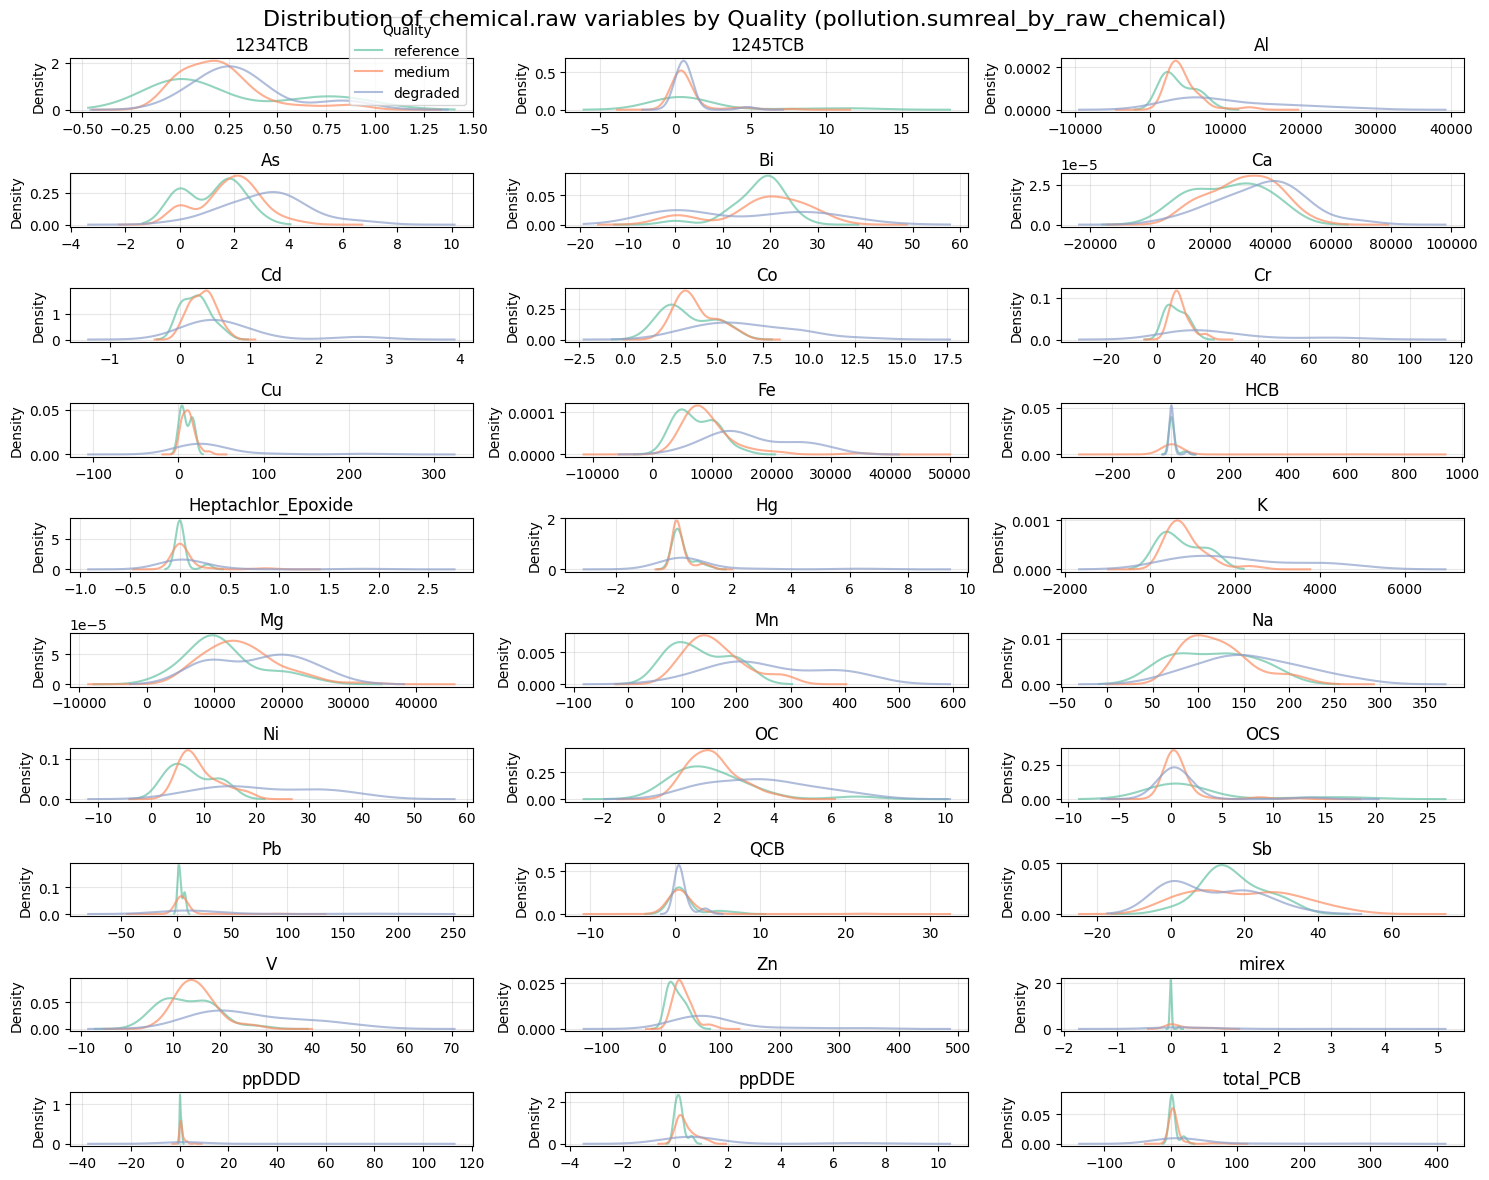

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visualize_subblock_by_label(df, block_name, subblock_name, label_var, 
                               label_block=None, label_subblock=None,
                               variables=None, plot_type='density', 
                               figsize=(15, 10), ncols=3):
    """
    Visualize the distribution of variables in a subblock grouped by a label variable.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The master dataframe with multi-level column structure
    block_name : str
        Name of the block containing the variables to visualize
    subblock_name : str
        Name of the subblock containing the variables to visualize
    label_var : str
        Name of the variable to group by
    label_block : str, optional
        Name of the block containing the label variable. If None, uses block_name
    label_subblock : str, optional
        Name of the subblock containing the label variable. If None, uses subblock_name
    variables : list, optional
        List of specific variables to plot. If None, plots all variables in subblock
    plot_type : str, default 'density'
        Type of plot: 'density', 'box', 'violin', 'hist'
    figsize : tuple, default (15, 10)
        Figure size
    ncols : int, default 3
        Number of columns for subplots
        
    Returns:
    --------
    matplotlib.figure.Figure : The created figure
    """
    # Extract the subblock data
    subblock_data = df[(block_name, subblock_name)]
    
    # Get label column from specified block/subblock or same subblock
    if label_block is not None and label_subblock is not None:
        # Label comes from different block/subblock
        try:
            labels = df[(label_block, label_subblock, label_var)]
        except KeyError:
            raise ValueError(f"Label variable '{label_var}' not found in {label_block}.{label_subblock}")
    else:
        # Label comes from same subblock
        if label_var not in subblock_data.columns:
            raise ValueError(f"Label variable '{label_var}' not found in {block_name}.{subblock_name}")
        labels = subblock_data[label_var]
    
    # Get variables to plot (excluding label variable if it's in the same subblock)
    if variables is None:
        variables = [col for col in subblock_data.columns if col != label_var]
    else:
        # Check if all variables exist
        missing_vars = [var for var in variables if var not in subblock_data.columns]
        if missing_vars:
            raise ValueError(f"Variables not found: {missing_vars}")
    
    # Calculate subplot layout
    nrows = (len(variables) + ncols - 1) // ncols
    
    # Create figure and subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    
    # Get unique labels for color mapping
    unique_labels = labels.unique()
    colors = sns.color_palette("Set2", len(unique_labels))
    
    # Plot each variable
    for i, var in enumerate(variables):
        row, col = divmod(i, ncols)
        ax = axes[row, col]
        
        if plot_type == 'density':
            for j, label in enumerate(unique_labels):
                mask = labels == label
                data = subblock_data.loc[mask, var]
                data.plot.density(ax=ax, label=label, color=colors[j], alpha=0.7)
            
        elif plot_type == 'box':
            data_for_box = [subblock_data.loc[labels == label, var] for label in unique_labels]
            box_plot = ax.boxplot(data_for_box, labels=unique_labels, patch_artist=True)
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
                
        elif plot_type == 'violin':
            data_list = []
            label_list = []
            for label in unique_labels:
                mask = labels == label
                data_list.extend(subblock_data.loc[mask, var].tolist())
                label_list.extend([label] * mask.sum())
            
            violin_data = pd.DataFrame({'value': data_list, 'label': label_list})
            sns.violinplot(data=violin_data, x='label', y='value', ax=ax, palette=colors)
            
        elif plot_type == 'hist':
            for j, label in enumerate(unique_labels):
                mask = labels == label
                data = subblock_data.loc[mask, var]
                ax.hist(data, alpha=0.6, label=label, color=colors[j], bins=20)
        
        ax.set_title(f'{var}')
        ax.set_xlabel('')
        # if plot_type in ['density', 'hist']:
        #     ax.legend()
        ax.grid(True, alpha=0.3)
    
    axes[0,0].legend(title=label_var)
    # Hide empty subplots
    for i in range(len(variables), nrows * ncols):
        row, col = divmod(i, ncols)
        axes[row, col].set_visible(False)
    
    # Add overall title
    label_source = f"{label_block}.{label_subblock}" if label_block and label_subblock else f"{block_name}.{subblock_name}"
    fig.suptitle(f'Distribution of {block_name}.{subblock_name} variables by {label_var} ({label_source})', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout()
    return fig

# Visualize chemical concentrations by pollution quality
fig = visualize_subblock_by_label(
    master_with_pollution,
    block_name='chemical',
    subblock_name='raw', 
    label_var='Quality',
    label_block='pollution',
    label_subblock='sumreal_by_raw_chemical',
    variables=None,
    plot_type='density',
    figsize=(15, 12),
    ncols=3
)

plt.show()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_27377/1611472709.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  pollution_data = master_with_pollution[('pollution', 'sumreal_by_logz_chemical')]


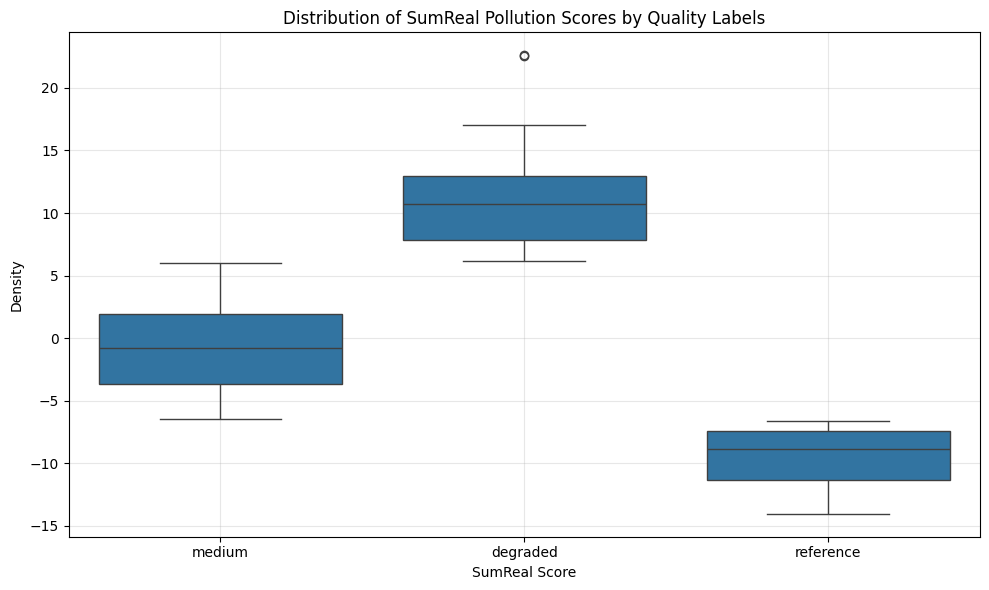

In [307]:
# Visualize the distribution of SumReal pollution scores by Quality labels using seaborn
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Extract the pollution data
pollution_data = master_with_pollution[('pollution', 'sumreal_by_logz_chemical')]

# Create a dataframe for seaborn plotting
plot_data = pd.DataFrame({
    'SumReal': pollution_data['SumReal'],
    'Quality': pollution_data['Quality']
})

# Create density plot with seaborn
sns.boxplot(data=plot_data, x='Quality', y='SumReal', ax=ax)

ax.set_title('Distribution of SumReal Pollution Scores by Quality Labels')
ax.set_xlabel('SumReal Score')
ax.set_ylabel('Density')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Check the chemical concentration distributions in the original ranked sites

In [296]:
original_rank = pd.read_excel("/Users/gufeng/Downloads/site_rank_test.xlsx")
original_rank.columns = ["StationID", "Rank"]
original_rank.head(10)

original_rank = original_rank.sort_values(by="Rank")
original_rank['rank'] = range(1, len(original_rank) + 1)
original_rank['quality'] = original_rank.apply(lambda x: 'reference' if x['rank'] <= 20 else ('medium' if x['rank'] <= 80 else 'degraded'), axis=1)
original_rank

,StationID,Rank,rank,quality
17,S81,21,1,reference
4,S72,22,2,reference
0,S70,23,3,reference
1,S74,40,4,reference
2,S53,43,5,reference
...,...,...,...,...
92,DJC2,99,96,degraded
95,S10,100,97,degraded
98,S27,100,98,degraded
97,UJC1,100,99,degraded


In [297]:
def merge_rank_data(master_df, rank_df, block_name="original", subblock_name="rank"):
    """
    Merge rank data into master dataframe with multi-level column structure.
    
    Parameters:
    -----------
    master_df : pandas.DataFrame
        The master dataframe with multi-level column structure
    rank_df : pandas.DataFrame
        The rank dataframe with StationID as foreign key
    block_name : str, default "original"
        Name for the new block in the dataframe
    subblock_name : str, default "rank"
        Name for the subblock in the dataframe
        
    Returns:
    --------
    pandas.DataFrame : Updated master dataframe with rank block added
    """
    # Create a copy of the master dataframe
    master_updated = master_df.copy()
    
    # Get columns from rank_df excluding StationID (the foreign key)
    rank_columns = [col for col in rank_df.columns if col != 'StationID']
    
    # Create multi-level column names for rank data
    for col in rank_columns:
        multi_col = (block_name, subblock_name, col)
        # Merge the data using StationID as key
        merged_data = master_df.index.to_series().map(rank_df.set_index('StationID')[col])
        master_updated[multi_col] = merged_data
    
    # Print summary
    print(f"Rank data merged into master dataframe:")
    print(f"Block: {block_name}, Subblock: {subblock_name}")
    print(f"Columns added: {rank_columns}")
    print(f"Matched stations: {merged_data.notna().sum()}/{len(master_df)}")
    
    return master_updated

# Merge the original rank data
master_with_rank = merge_rank_data(
    master_with_pollution, 
    original_rank, 
    block_name="original", 
    subblock_name="rank"
)

# Display the new rank block
rank_block = master_with_rank[('original', 'rank')]
print("\nOriginal rank block added to master dataframe:")
print(rank_block.head(10))

Rank data merged into master dataframe:
Block: original, Subblock: rank
Columns added: ['Rank', 'rank', 'quality']
Matched stations: 100/104

Original rank block added to master dataframe:
var        Rank  rank    quality
StationID                       
A10        54.0  14.0  reference
A23        79.0  38.0     medium
A27        93.0  73.0     medium
A28        92.0  69.0     medium
A29        99.0  93.0   degraded
A5         54.0  15.0  reference
A53        92.0  71.0     medium
A58        90.0  66.0     medium
A6         94.0  78.0     medium
A66        64.0  21.0     medium


/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_27377/2769123438.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  rank_block = master_with_rank[('original', 'rank')]


In [298]:
# Group by original rank quality and aggregate chemical data
chemical_by_original_quality = groupby_aggregation(
    master_with_rank,
    groupby_block="original",
    groupby_subblock="rank", 
    groupby_var="quality",
    agg_block="chemical",
    agg_subblock="raw",
    agg_functions="mean"
)

# Display the results
chemical_by_original_quality_transposed = chemical_by_original_quality.T.round(3)
print("Chemical concentrations by original rank quality:")
print(chemical_by_original_quality_transposed)

Chemical concentrations by original rank quality:
original_rank_quality   degraded     medium  reference
var                                                   
1234TCB                    0.208      0.251      0.207
1245TCB                    2.617      0.650      0.275
Al                      9611.150   4787.067   3126.150
As                         2.096      1.851      2.216
Bi                        18.919     18.217     16.907
Ca                     37511.650  32508.833  20900.700
Cd                         0.523      0.335      0.145
Co                         6.162      3.951      3.209
Cr                        16.482      9.497      7.355
Cu                        20.155     12.565     10.023
Fe                     14453.850   9553.350   7014.900
HCB                       15.170      3.303      0.506
Heptachlor_Epoxide         0.237      0.030      0.000
Hg                         0.567      0.252      0.056
K                       2025.360    962.127    504.805
Mg             

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_27377/1464447614.py:35: PerformanceWarning: indexing past lexsort depth may impact performance.
  agg_data = df[(agg_block, agg_subblock)]


In [299]:
chemical_by_original_quality_transposed

original_rank_quality,degraded,medium,reference
var,,,
1234TCB,0.208,0.251,0.207
1245TCB,2.617,0.650,0.275
Al,9611.150,4787.067,3126.150
As,2.096,1.851,2.216
Bi,18.919,18.217,16.907
Ca,37511.650,32508.833,20900.700
Cd,0.523,0.335,0.145
Co,6.162,3.951,3.209
Cr,16.482,9.497,7.355
